# Import libraries

In [94]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Connect to database

In [95]:
# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [96]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

# Retrieve relevant data from the database

In [97]:
query="""
    select *
    from agg.tidy_data_30min 
    where site = 20
"""

In [98]:
df = pd.read_sql_query(query, conn)

C:\Users\elian\AppData\Local\Temp\ipykernel_293588\1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   timestamp                  17562 non-null  datetime64[ns, UTC]
 1   site                       17562 non-null  int64              
 2   year                       17562 non-null  int64              
 3   month                      17562 non-null  int64              
 4   day                        17562 non-null  int64              
 5   hour                       17562 non-null  int64              
 6   minute                     17562 non-null  int64              
 7   day_of_week                17562 non-null  int64              
 8   season                     17562 non-null  int64              
 9   net_load                   17562 non-null  float64            
 10  precipitation              17068 non-null  float64            
 11  pr

In [100]:
df

,timestamp,site,year,month,day,hour,minute,day_of_week,season,net_load,...,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,q25_net_load,q75_net_load,median_net_load,weekend_or_bank_holiday
0,2019-04-23 15:30:00+00:00,20,2019,4,23,16,30,1,2,10.35,...,NaN,NaN,NaN,NaN,NaN,-24.74,-34.7600,16.66,5.71,0
1,2019-04-23 16:00:00+00:00,20,2019,4,23,17,0,1,2,16.79,...,NaN,NaN,NaN,NaN,NaN,5.20,-11.6750,17.73,9.42,0
2,2019-04-23 16:30:00+00:00,20,2019,4,23,17,30,1,2,16.98,...,NaN,NaN,NaN,NaN,NaN,28.17,5.0250,28.62,15.78,0
3,2019-04-23 17:00:00+00:00,20,2019,4,23,18,0,1,2,11.89,...,NaN,NaN,NaN,NaN,NaN,53.22,11.9125,28.25,16.16,0
4,2019-04-23 17:30:00+00:00,20,2019,4,23,18,30,1,2,24.23,...,NaN,NaN,NaN,NaN,NaN,50.42,12.8475,31.11,17.33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,2020-03-30 04:30:00+00:00,20,2020,3,30,5,30,0,2,511.06,...,NaN,NaN,NaN,NaN,NaN,608.02,16.3600,570.76,147.54,0
17558,2020-03-30 05:00:00+00:00,20,2020,3,30,6,0,0,2,320.69,...,NaN,NaN,NaN,NaN,NaN,586.85,42.6575,635.50,216.76,0
17559,2020-03-30 05:30:00+00:00,20,2020,3,30,6,30,0,2,245.21,...,NaN,NaN,NaN,NaN,NaN,524.16,50.5500,616.78,256.78,0
17560,2020-03-30 06:00:00+00:00,20,2020,3,30,7,0,0,2,187.68,...,NaN,NaN,NaN,NaN,NaN,458.60,28.3925,428.11,144.64,0


In [101]:
# Convert 'ts' to datetime and set as index
# df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.set_index('timestamp', drop=False)
df = df.sort_index()

df

,timestamp,site,year,month,day,hour,minute,day_of_week,season,net_load,...,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,q25_net_load,q75_net_load,median_net_load,weekend_or_bank_holiday
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-04-01 00:00:00+00:00,2019-04-01 00:00:00+00:00,20,2019,4,1,1,0,0,2,198.79,...,2.0,87.0,12.0,0.0,0.0,152.86,15.4150,138.56,18.69,0
2019-04-01 00:30:00+00:00,2019-04-01 00:30:00+00:00,20,2019,4,1,1,30,0,2,250.51,...,2.0,87.0,12.0,0.0,0.0,204.52,15.3175,166.11,18.60,0
2019-04-01 01:00:00+00:00,2019-04-01 01:00:00+00:00,20,2019,4,1,2,0,0,2,194.07,...,3.0,89.0,11.0,0.0,0.0,214.66,15.8375,179.70,31.03,0
2019-04-01 01:30:00+00:00,2019-04-01 01:30:00+00:00,20,2019,4,1,2,30,0,2,245.33,...,3.0,89.0,11.0,0.0,0.0,209.72,15.8775,177.33,52.99,0
2019-04-01 02:00:00+00:00,2019-04-01 02:00:00+00:00,20,2019,4,1,3,0,0,2,223.68,...,4.0,91.0,11.0,0.0,0.0,230.59,16.3350,212.62,65.21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:30:00+00:00,2020-03-31 20:30:00+00:00,20,2020,3,31,21,30,1,2,28.10,...,NaN,NaN,NaN,NaN,NaN,282.00,15.4650,264.64,19.82,0
2020-03-31 21:00:00+00:00,2020-03-31 21:00:00+00:00,20,2020,3,31,22,0,1,2,11.10,...,NaN,NaN,NaN,NaN,NaN,321.01,14.5975,220.50,16.55,0
2020-03-31 21:30:00+00:00,2020-03-31 21:30:00+00:00,20,2020,3,31,22,30,1,2,196.48,...,NaN,NaN,NaN,NaN,NaN,353.42,14.7625,206.66,30.23,0


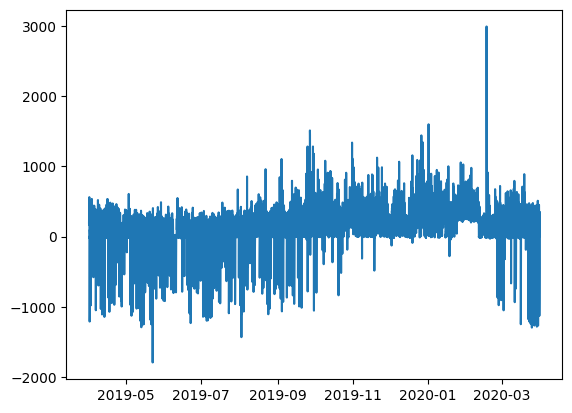

In [102]:
plt.plot(df.index, df.net_load)
plt.show()

# Normalise net load (as seen in literature)

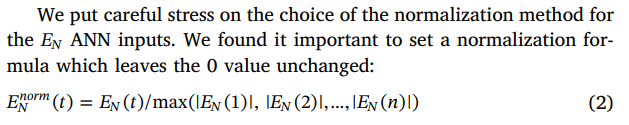



High-resolution net load forecasting for micro-neighbourhoods with high
penetration of renewable energy sources
P. Kobylinskia
, M. Wierzbowskia
, K. Piotrowskib,

In [103]:
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))

df

,timestamp,site,year,month,day,hour,minute,day_of_week,season,net_load,...,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,q25_net_load,q75_net_load,median_net_load,weekend_or_bank_holiday,net_load_norm
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-04-01 00:00:00+00:00,2019-04-01 00:00:00+00:00,20,2019,4,1,1,0,0,2,198.79,...,87.0,12.0,0.0,0.0,152.86,15.4150,138.56,18.69,0,0.066453
2019-04-01 00:30:00+00:00,2019-04-01 00:30:00+00:00,20,2019,4,1,1,30,0,2,250.51,...,87.0,12.0,0.0,0.0,204.52,15.3175,166.11,18.60,0,0.083742
2019-04-01 01:00:00+00:00,2019-04-01 01:00:00+00:00,20,2019,4,1,2,0,0,2,194.07,...,89.0,11.0,0.0,0.0,214.66,15.8375,179.70,31.03,0,0.064875
2019-04-01 01:30:00+00:00,2019-04-01 01:30:00+00:00,20,2019,4,1,2,30,0,2,245.33,...,89.0,11.0,0.0,0.0,209.72,15.8775,177.33,52.99,0,0.082010
2019-04-01 02:00:00+00:00,2019-04-01 02:00:00+00:00,20,2019,4,1,3,0,0,2,223.68,...,91.0,11.0,0.0,0.0,230.59,16.3350,212.62,65.21,0,0.074773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:30:00+00:00,2020-03-31 20:30:00+00:00,20,2020,3,31,21,30,1,2,28.10,...,NaN,NaN,NaN,NaN,282.00,15.4650,264.64,19.82,0,0.009393
2020-03-31 21:00:00+00:00,2020-03-31 21:00:00+00:00,20,2020,3,31,22,0,1,2,11.10,...,NaN,NaN,NaN,NaN,321.01,14.5975,220.50,16.55,0,0.003711
2020-03-31 21:30:00+00:00,2020-03-31 21:30:00+00:00,20,2020,3,31,22,30,1,2,196.48,...,NaN,NaN,NaN,NaN,353.42,14.7625,206.66,30.23,0,0.065681


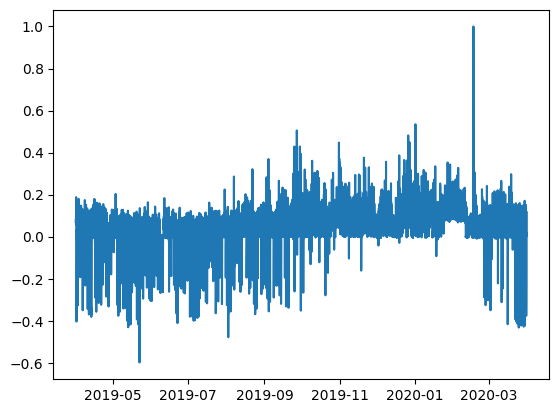

In [104]:
plt.plot(df.index, df.net_load_norm)
plt.show()

# Prepare data set for LSTM

Example \
Based on the first 5 hours, let's predict the 6th hour\
Based on the next 5 hours, let's predict the 7th hour\
etc. etc.

[[[1], [2], [3], [4], [5]]] [6] \
[[[2], [3], [4], [5], [6]]] [7] \
[[[3], [4], [5], [6], [7]]] [8]

### Set parameters

In [105]:
# Parameters

#n_input = no. of time steps considered before making the prediction
#n_features = no. of variables/features considered
#n_output = no. of time steps to forecast

# Note: 1 time step = 30 mins
# Look at the last two weeks to forecast the next 36 hours

# 1 day = 2 * 24 * 1 = 24
# 2 hours = 2 * 2 = 8 

n_input = 144
n_features = 2
n_output = 72


# Select which features are to be inputted into the LSTM i.e., which columns in the df
df_input = df[['net_load_norm', 'weekend_or_bank_holiday']]
df_input

,net_load_norm,weekend_or_bank_holiday
timestamp,,
2019-04-01 00:00:00+00:00,0.066453,0
2019-04-01 00:30:00+00:00,0.083742,0
2019-04-01 01:00:00+00:00,0.064875,0
2019-04-01 01:30:00+00:00,0.082010,0
2019-04-01 02:00:00+00:00,0.074773,0
...,...,...
2020-03-31 20:30:00+00:00,0.009393,0
2020-03-31 21:00:00+00:00,0.003711,0
2020-03-31 21:30:00+00:00,0.065681,0


In [106]:
df_input.isnull().isnull().sum()

net_load_norm              0
weekend_or_bank_holiday    0
dtype: int64

In [107]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17562 entries, 2019-04-01 00:00:00+00:00 to 2020-03-31 22:30:00+00:00
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   net_load_norm            17562 non-null  float64
 1   weekend_or_bank_holiday  17562 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 411.6 KB


### Generate the X and y matrices

In [108]:
# X, y = [], []
# for i in range(len(df_input) - n_input - n_output + 1):
#     X.append(df_input[i:(i + n_input), 0])
#     y.append(df_input['net_load_norm'][(i + n_input):(i + n_input + n_output), 0])

# X = np.array(X).reshape((len(X), n_input, n_features))
# y = np.array(y)


# X, y = [], []
# for i in range(n_input, len(df_input) - n_output + 1):
#     X.append(df_input[i - n_input : i,0 : df_input.shape[1]])
#     y.append(df_input[i + n_output - 1 : i + n_output, 0])

# X = np.array(X).reshape((len(X), n_input, n_features))
# y = np.array(y)

# X, y = [], []
# for i in range(len(df_input) - n_input - n_output + 1):
#     X.append(df_input.iloc[i:(i + n_input), 0].values)  # Assuming 0 is the correct column index
#     y.append(df_input['net_load_norm'].iloc[i + n_input:i + n_input + n_output].values)

# X = np.array(X).reshape((len(X), n_input, -1))  # Adjusted for n_features
# y = np.array(y)

X, y = [], []
for i in range(len(df_input) - n_input - n_output + 1):
    # Select all columns for the input sequence
    X.append(df_input.iloc[i:(i + n_input)].values)  
    
    y.append(df_input['net_load_norm'].iloc[(i + n_input):(i + n_input + n_output)].values)

X = np.array(X).reshape((len(X), n_input, -1))  
y = np.array(y)

In [109]:
X.shape

(17347, 144, 2)

In [110]:
y.shape

(17347, 72)

First set of X and y values

In [111]:
print(f'Given the array X: \n {X[0].flatten()}\n')
print(f'Predict this y: \n {y[0]}\n')

Given the array X: 
 [ 6.64527236e-02  0.00000000e+00  8.37419980e-02  0.00000000e+00
  6.48748934e-02  0.00000000e+00  8.20103963e-02  0.00000000e+00
  7.47731033e-02  0.00000000e+00  5.94661452e-02  0.00000000e+00
  8.81880025e-02  0.00000000e+00  6.03085460e-02  0.00000000e+00
  7.36031022e-02  0.00000000e+00  5.57756272e-02  0.00000000e+00
  1.38464624e-01  0.00000000e+00  1.16301459e-01  0.00000000e+00
  1.88039245e-01  0.00000000e+00  8.53164853e-02  0.00000000e+00
  3.56148356e-02  0.00000000e+00 -4.99089071e-03  0.00000000e+00
 -4.59643317e-03  0.00000000e+00 -5.35860536e-03  0.00000000e+00
 -7.10023567e-03  0.00000000e+00 -2.91497434e-03  0.00000000e+00
 -2.72443130e-03  0.00000000e+00  1.05300105e-03  0.00000000e+00
 -1.89637132e-01  0.00000000e+00 -3.79742265e-01  0.00000000e+00
 -4.04004747e-01  0.00000000e+00 -3.58144044e-01  0.00000000e+00
 -3.78799579e-01  0.00000000e+00 -3.72698858e-01  0.00000000e+00
 -3.32761704e-01  0.00000000e+00 -2.38543181e-01  0.00000000e+00
 -2.

Second set of X and y values

In [112]:
print(f'Given the array X: \n {X[1].flatten()}\n')
print(f'Predict this y: \n {y[1]}\n')

Given the array X: 
 [ 8.37419980e-02  0.00000000e+00  6.48748934e-02  0.00000000e+00
  8.20103963e-02  0.00000000e+00  7.47731033e-02  0.00000000e+00
  5.94661452e-02  0.00000000e+00  8.81880025e-02  0.00000000e+00
  6.03085460e-02  0.00000000e+00  7.36031022e-02  0.00000000e+00
  5.57756272e-02  0.00000000e+00  1.38464624e-01  0.00000000e+00
  1.16301459e-01  0.00000000e+00  1.88039245e-01  0.00000000e+00
  8.53164853e-02  0.00000000e+00  3.56148356e-02  0.00000000e+00
 -4.99089071e-03  0.00000000e+00 -4.59643317e-03  0.00000000e+00
 -5.35860536e-03  0.00000000e+00 -7.10023567e-03  0.00000000e+00
 -2.91497434e-03  0.00000000e+00 -2.72443130e-03  0.00000000e+00
  1.05300105e-03  0.00000000e+00 -1.89637132e-01  0.00000000e+00
 -3.79742265e-01  0.00000000e+00 -4.04004747e-01  0.00000000e+00
 -3.58144044e-01  0.00000000e+00 -3.78799579e-01  0.00000000e+00
 -3.72698858e-01  0.00000000e+00 -3.32761704e-01  0.00000000e+00
 -2.38543181e-01  0.00000000e+00 -2.34521720e-01  0.00000000e+00
 -1.

# Split into train (First 330 days) and test (the rest i.e., ~30 days depending on how big the n_input variable is set )

In [193]:
# 1 time step = 30 mins

n_split = 2 * 24 * 324

X_train = X[:n_split]
y_train = y[:n_split]

X_test = X[n_split:]
y_test = y[n_split:]

In [153]:
X_train.shape

(14400, 144, 2)

In [154]:
y_train.shape

(14400, 72)

In [155]:
X_test.shape

(2947, 144, 2)

In [156]:
y_test.shape

(2947, 72)

# Build LSTM model

### Model 1

In [161]:
model1 = Sequential()
# model1.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model1.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True ))
model1.add(LSTM(32, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(y_train.shape[1]))

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 144, 64)           17152     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 72)                2376      
                                                                 
Total params: 31,944
Trainable params: 31,944
Non-trainable params: 0
_________________________________________________________________


In [162]:
cp1 = ModelCheckpoint('multivar_Noutput72_Ninput336_noweather.keras', save_best_only=True)
model1.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[MeanSquaredError(), MeanAbsoluteError()])

# Fit LSTM model

In [163]:
history = model1.fit(X_train, y_train, epochs=10, callbacks=[cp1], batch_size=16, validation_split=0.1)
# history = model1.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1)

Epoch 1/10
891/891 [==============================] - 43s 47ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0522 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0367
Epoch 2/10
891/891 [==============================] - 41s 46ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0463 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0378
Epoch 3/10
891/891 [==============================] - 45s 50ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0450 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0371
Epoch 4/10
891/891 [==============================] - 46s 51ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0443 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0377
Epoch 5/10
891/891 [==============================] - 46s 51ms/step - loss: 0.0042 - mea

# Check training results

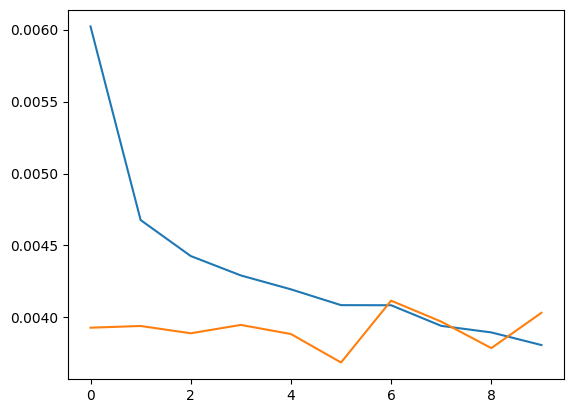

In [164]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Plot training results

In [165]:
# Select every n_output-th sample 

# This will be the inputs into the LSTM model

X_train_input = X_train[::n_output]
y_train_input = y_train[::n_output]

In [166]:
df_ts_train = df_input[n_input+n_output:]

In [75]:
X_train_input.shape

(200, 144, 2)

In [76]:
y_train_input.shape

(200, 72)

In [77]:
print(f"n_ouput: {n_output}")

n_ouput: 72


1/1 [==============================] - 0s 44ms/step


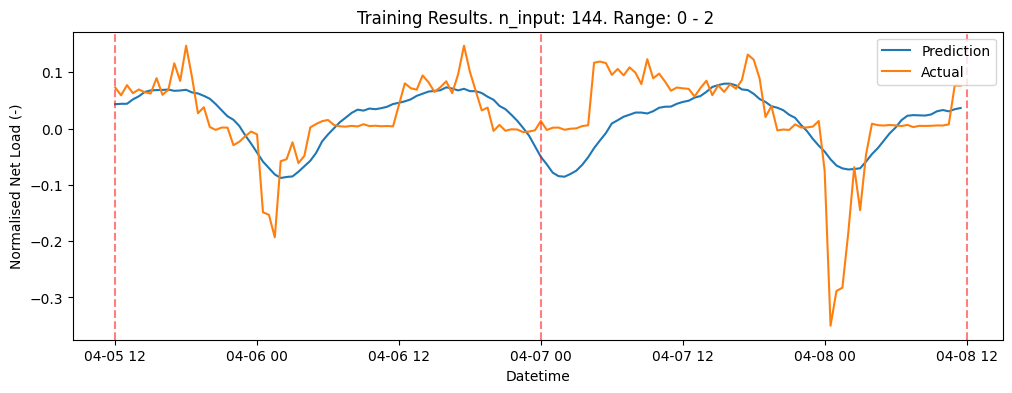

In [78]:
# Parameters to change to better visualise the training results

# 1 = n_output e.g., 24 hours or maybe 1 week depending

start_section = 0
end_section = 2
diff = end_section-start_section


predictions = []

for i in X_train_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)
    prediction = model1.predict(i_reshaped)

    prediction_list = list(prediction[0])
    predictions.append(prediction_list)

plt.figure(figsize=(12,4))
plt.title(f"Training Results. n_input: {n_input}. Range: {start_section} - {end_section} ")
plt.plot(df_ts_train.index[start_section*n_output: end_section*n_output], np.array(predictions).flatten(), label='Prediction')
plt.plot(df_ts_train.index[start_section*n_output: end_section*n_output], y_train_input[start_section:end_section].flatten(), label = 'Actual')
plt.xlabel('Datetime')
plt.ylabel('Normalised Net Load (-)')

# xcoords = [(i*n_output)-1+n_output for i in range(diff)]
xcoords = df_ts_train.index[start_section*n_output:(end_section+1)*n_output][::n_output]

for xc in xcoords:
    plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)


plt.legend()

### Plot training results v2

![](<attachment:WhatsApp Image 2024-04-01 at 22.47.27_9c903532.jpg>)
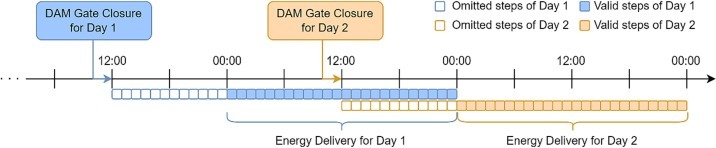

Create a df_ts_train to keep track of the datetime values for the train predictions so we can plot them on the x-axis when visualising

In [194]:
df_ts_train = df_input[n_input+n_output:]

Below is when the first y_train prediction starts. Which aligns with the 12:00 of the DAM Gate Closure for Day 1.

In [195]:
df_ts_train.index[0]

Timestamp('2019-04-05 12:00:00+0000', tz='UTC')

We want to predict every 24 hours i.e., 48 time steps. This is from one DAM gate closure to another DAM gate closure.

In [196]:
X_train_input = X_train[::48]
y_train_input = y_train[::48]

Below shows we have 330 days for train

In [197]:
X_train_input.shape

(324, 144, 2)

1/1 [==============================] - 0s 26ms/step


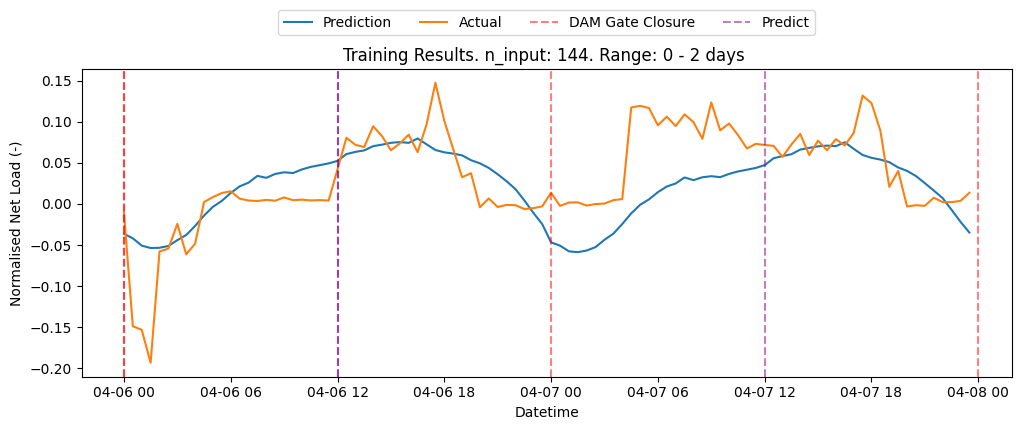

In [172]:
# Parameters to change to better visualise the training results

# 1 = number of days i.e., 24 hours i.e., 48 time steps

start_section = 0
end_section = 2
diff = end_section-start_section

predictions = []

for i in X_train_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)

    prediction = model1.predict(i_reshaped)

     # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
    prediction_list = list(prediction[0][24:])
    predictions.append(prediction_list)


y_train_input_24h = []

for i in y_train_input[start_section:end_section]:
    # i_reshaped = i.reshape(1, n_input, n_features)
    y_train_input_24h.append(i[24:])
    

plt.figure(figsize=(12,4))
plt.title(f"Training Results. n_input: {n_input}. Range: {start_section} - {end_section} days ")

# We want to plot the predictions from 00:00 to 00:00 the next day.
plt.plot(df_ts_train.index[start_section*48+24: end_section*48+24], np.array(predictions).flatten(), label='Prediction')
plt.plot(df_ts_train.index[start_section*48+24: end_section*48+24], np.array(y_train_input_24h).flatten(), label = 'Actual')
plt.xlabel('Datetime')
plt.ylabel('Normalised Net Load (-)')



# Generate vertical lines for DAM closure
xcoords_DAM = df_ts_train.index[start_section*48+24: (end_section+1)*48+24][::48]

for xc in xcoords_DAM:
    plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)

plt.axvline(x=xcoords_DAM[0], color='red', linestyle='--', alpha=0.5, label='DAM Gate Closure')


# Generate vertical lines for when we predict
xcoords_DAM = df_ts_train.index[(start_section+1)*48: (end_section+1)*48][::48]

for xc in xcoords_DAM:
    plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.5)

plt.axvline(x=xcoords_DAM[0], color='purple', linestyle='--', alpha=0.5, label='Predict')


plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', borderaxespad=0., ncol=4)


# Plot testing results

In [ ]:
# Select every n_output-th sample 

# This will be the inputs into the LSTM model

X_test_input = X_test[::n_output]
y_test_input = y_test[::n_output]

In [ ]:
X_test_input.shape

In [ ]:
y_test_input.shape

In [ ]:
# Parameters to change to better visualise the training results

# 1 = n_output e.g., 24 hours or maybe 1 week depending

start_section = 0
end_section = 10
diff = end_section-start_section


predictions = []

for i in X_test_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)
    prediction = model1.predict(i_reshaped)

    prediction_list = list(prediction[0])
    predictions.append(prediction_list)

plt.figure(figsize=(12,4))
plt.title(f"Testing Results. n_input: {n_input}. Range: {start_section} - {end_section} ")
plt.plot(np.array(predictions).flatten(), label='Prediction')
plt.plot(y_test_input[start_section:end_section].flatten(), label = 'Actual')
plt.xlabel('Index')
plt.ylabel('Normalised Net Load (-)')

xcoords = [(i*n_output)-1+n_output for i in range(diff)]
for xc in xcoords:
    plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)


plt.legend()

### Plot testing results v2

![](<attachment:WhatsApp Image 2024-04-01 at 22.47.27_8a15aa7b.jpg>)
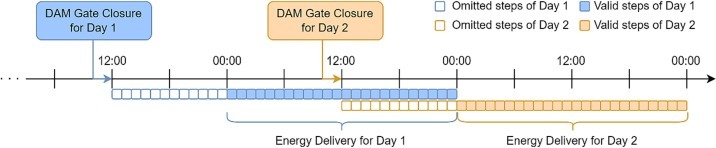

Create a df_ts_train to keep track of the datetime values for the train predictions so we can plot them on the x-axis when visualising

In [198]:
df_ts_test = df_input[n_input+n_output+n_split:]

Below is when the first y_test prediction starts. Which aligns with the 12:00 of the DAM Gate Closure for Day 1.

In [199]:
df_ts_test.index[0]

Timestamp('2020-02-23 12:00:00+0000', tz='UTC')

We want to predict every 24 hours i.e., 48 time steps. This is from one DAM gate closure to another DAM gate closure.

In [200]:
X_test_input = X_test[::48]
y_test_input = y_test[::48]

Below shows we have 32 days for test

In [201]:
X_test_input.shape

(38, 144, 2)

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 36ms/step


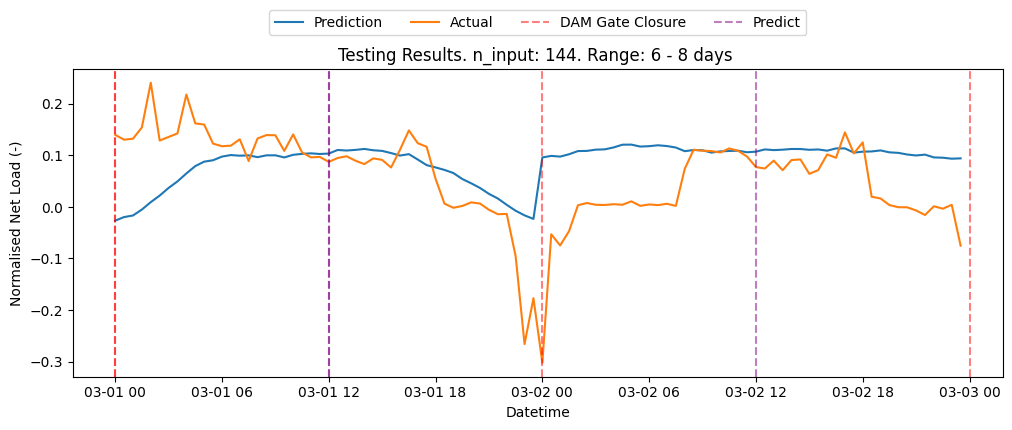

In [211]:
# Parameters to change to better visualise the training results

# 1 = number of days i.e., 24 hours i.e., 48 time steps

start_section = 6
end_section = 8
diff = end_section-start_section

predictions = []

for i in X_test_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)

    prediction = model1.predict(i_reshaped)

     # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
    prediction_list = list(prediction[0][24:])
    predictions.append(prediction_list)


y_test_input_24h = []

for i in y_test_input[start_section:end_section]:
    # i_reshaped = i.reshape(1, n_input, n_features)
    y_test_input_24h.append(i[24:])
    

plt.figure(figsize=(12,4))
plt.title(f"Testing Results. n_input: {n_input}. Range: {start_section} - {end_section} days ")

# We want to plot the predictions from 00:00 to 00:00 the next day.
plt.plot(df_ts_test.index[start_section*48+24: end_section*48+24], np.array(predictions).flatten(), label='Prediction')
plt.plot(df_ts_test.index[start_section*48+24: end_section*48+24], np.array(y_test_input_24h).flatten(), label = 'Actual')
plt.xlabel('Datetime')
plt.ylabel('Normalised Net Load (-)')



# Generate vertical lines for DAM closure
xcoords_DAM = df_ts_test.index[start_section*48+24: (end_section+1)*48+24][::48]

for xc in xcoords_DAM:
    plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)

plt.axvline(x=xcoords_DAM[0], color='red', linestyle='--', alpha=0.5, label='DAM Gate Closure')


# Generate vertical lines for when we predict
xcoords_DAM = df_ts_test.index[(start_section+1)*48: (end_section+1)*48][::48]

for xc in xcoords_DAM:
    plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.5)

plt.axvline(x=xcoords_DAM[0], color='purple', linestyle='--', alpha=0.5, label='Predict')


plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', borderaxespad=0., ncol=4)

In [191]:
df['net_load_norm'].index

DatetimeIndex(['2019-04-01 00:00:00+00:00', '2019-04-01 00:30:00+00:00',
               '2019-04-01 01:00:00+00:00', '2019-04-01 01:30:00+00:00',
               '2019-04-01 02:00:00+00:00', '2019-04-01 02:30:00+00:00',
               '2019-04-01 03:00:00+00:00', '2019-04-01 03:30:00+00:00',
               '2019-04-01 04:00:00+00:00', '2019-04-01 04:30:00+00:00',
               ...
               '2020-03-31 18:00:00+00:00', '2020-03-31 18:30:00+00:00',
               '2020-03-31 19:00:00+00:00', '2020-03-31 19:30:00+00:00',
               '2020-03-31 20:00:00+00:00', '2020-03-31 20:30:00+00:00',
               '2020-03-31 21:00:00+00:00', '2020-03-31 21:30:00+00:00',
               '2020-03-31 22:00:00+00:00', '2020-03-31 22:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='timestamp', length=17562, freq=None)